# 1.0  Data Preparation

## GADM Shapefile (Admin Boundaries)

We use the GADM shapefile to load Kenya's county and sub-county boundaries. This helps us link food price and weather data to specific regions for analysis and visualization.


In [1]:
!wget -q https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_KEN_2.json.zip && unzip -oq gadm41_KEN_2.json.zip && rm gadm41_KEN_2.json.zip

In [2]:
#importing libraries
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

## 1.1 Load Datasets

We load food prices, market information, rainfall data, and Kenya's administrative boundaries to begin the data preparation process.


In [3]:
# Load food price dataset
prices = pd.read_csv("wfp_food_prices_ken.csv", comment='#')

# Load market locations and metadata
markets = pd.read_csv("wfp_markets_ken.csv", comment='#')

# Load county and sub-county boundaries (GADM Level 2)
counties = gpd.read_file("gadm41_KEN_2.json")

# Load county-level monthly rainfall data
rainfall = pd.read_csv("kenya_county_rainfall.csv")


In [4]:
#display the price data
prices

,date,admin1,admin2,market,market_id,latitude,longitude,category,commodity,commodity_id,unit,priceflag,pricetype,currency,price,usdprice
0,2006-01-15,Coast,Mombasa,Mombasa,191,-4.05,39.67,pulses and nuts,Beans,50,KG,actual,Wholesale,KES,33.63,0.47
1,2006-01-15,Eastern,Kitui,Kitui,187,-1.37,38.02,cereals and tubers,Potatoes (Irish),148,50 KG,actual,Wholesale,KES,1249.99,17.39
2,2006-01-15,Eastern,Kitui,Kitui,187,-1.37,38.02,cereals and tubers,Sorghum,65,90 KG,actual,Wholesale,KES,1800.00,25.03
3,2006-01-15,Eastern,Kitui,Kitui,187,-1.37,38.02,pulses and nuts,Beans (dry),262,KG,actual,Retail,KES,39.00,0.54
4,2006-01-15,Eastern,Marsabit,Marsabit,190,2.33,37.98,cereals and tubers,Maize (white),67,KG,actual,Retail,KES,21.00,0.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12777,2025-04-15,Rift Valley,Turkana,Kakuma 4,3249,3.74,34.81,miscellaneous food,Salt,185,200 G,aggregate,Retail,KES,11.67,0.09
12778,2025-04-15,Rift Valley,Turkana,Kakuma 4,3249,3.74,34.81,miscellaneous food,Sugar,97,KG,aggregate,Retail,KES,158.33,1.22
12779,2025-04-15,Rift Valley,Turkana,Kakuma 4,3249,3.74,34.81,oil and fats,Oil (vegetable),96,L,aggregate,Retail,KES,313.33,2.42
12780,2025-04-15,Rift Valley,Turkana,Kakuma 4,3249,3.74,34.81,pulses and nuts,Beans (dry),262,KG,aggregate,Retail,KES,151.67,1.17


## 1.2 Merge Prices with Rainfall Data

We merge the food prices dataset with rainfall data to incorporate weather context into our analysis.  
This helps us explore how rainfall patterns may affect food prices across counties and months.


In [5]:
# Create geometry column
geometry = [Point(xy) for xy in zip(prices["longitude"], prices["latitude"])]
gdf_markets = gpd.GeoDataFrame(prices, geometry=geometry, crs="EPSG:4326")


In [6]:
# Spatial join: assign county/district to each market
market_with_location = gpd.sjoin(gdf_markets, counties, how="left", predicate='within')

# Extract year-month from the custom CHIRPS format
rainfall['month'] = rainfall['date'].str.extract(r'(\d{4}\.\d{2})')
# For prices.csv (market_with_location)
market_with_location['month'] = pd.to_datetime(market_with_location['date']).dt.to_period('M').astype(str)

# For rainfall
rainfall['month'] = rainfall['month'].str.replace('.', '-', regex=False)

In [7]:
# Merge prices with rainfall data
prices_rainfall = pd.merge(
    market_with_location,
    rainfall,
    how="left",
    left_on=["NAME_1", "NAME_2", "month"],
    right_on=["county", "district", "month"]
)

prices_rainfall

,date_x,admin1,admin2,market,market_id,latitude,longitude,category,commodity,commodity_id,...,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,month,county,district,date_y,rainfall_mm
0,2006-01-15,Coast,Mombasa,Mombasa,191,-4.05,39.67,pulses and nuts,Beans,50,...,NA,Constituency,Constituency,6,NA,2006-01,Mombasa,Mvita,chirps-v3.0.2006.01,1.223553
1,2006-01-15,Eastern,Kitui,Kitui,187,-1.37,38.02,cereals and tubers,Potatoes (Irish),148,...,NA,Constituency,Constituency,72,NA,2006-01,Kitui,KituiCentral,chirps-v3.0.2006.01,14.709594
2,2006-01-15,Eastern,Kitui,Kitui,187,-1.37,38.02,cereals and tubers,Sorghum,65,...,NA,Constituency,Constituency,72,NA,2006-01,Kitui,KituiCentral,chirps-v3.0.2006.01,14.709594
3,2006-01-15,Eastern,Kitui,Kitui,187,-1.37,38.02,pulses and nuts,Beans (dry),262,...,NA,Constituency,Constituency,72,NA,2006-01,Kitui,KituiCentral,chirps-v3.0.2006.01,14.709594
4,2006-01-15,Eastern,Marsabit,Marsabit,190,2.33,37.98,cereals and tubers,Maize (white),67,...,NA,Constituency,Constituency,47,NA,2006-01,Marsabit,Saku,chirps-v3.0.2006.01,6.539468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12777,2025-04-15,Rift Valley,Turkana,Kakuma 4,3249,3.74,34.81,miscellaneous food,Salt,185,...,NA,Constituency,Constituency,124,NA,2025-04,Turkana,TurkanaWest,chirps-v3.0.2025.04,66.158401
12778,2025-04-15,Rift Valley,Turkana,Kakuma 4,3249,3.74,34.81,miscellaneous food,Sugar,97,...,NA,Constituency,Constituency,124,NA,2025-04,Turkana,TurkanaWest,chirps-v3.0.2025.04,66.158401
12779,2025-04-15,Rift Valley,Turkana,Kakuma 4,3249,3.74,34.81,oil and fats,Oil (vegetable),96,...,NA,Constituency,Constituency,124,NA,2025-04,Turkana,TurkanaWest,chirps-v3.0.2025.04,66.158401
12780,2025-04-15,Rift Valley,Turkana,Kakuma 4,3249,3.74,34.81,pulses and nuts,Beans (dry),262,...,NA,Constituency,Constituency,124,NA,2025-04,Turkana,TurkanaWest,chirps-v3.0.2025.04,66.158401


In [8]:
# Display the first few rows of the merged DataFrame
merged = pd.merge(prices_rainfall, markets, on='market_id', how='left')
print(merged.head(5))

       date_x admin1_x  admin2_x  market_x  market_id  latitude_x  \
0  2006-01-15    Coast   Mombasa   Mombasa        191       -4.05   
1  2006-01-15  Eastern     Kitui     Kitui        187       -1.37   
2  2006-01-15  Eastern     Kitui     Kitui        187       -1.37   
3  2006-01-15  Eastern     Kitui     Kitui        187       -1.37   
4  2006-01-15  Eastern  Marsabit  Marsabit        190        2.33   

   longitude_x            category         commodity  commodity_id  ...  \
0        39.67     pulses and nuts             Beans            50  ...   
1        38.02  cereals and tubers  Potatoes (Irish)           148  ...   
2        38.02  cereals and tubers           Sorghum            65  ...   
3        38.02     pulses and nuts       Beans (dry)           262  ...   
4        37.98  cereals and tubers     Maize (white)            67  ...   

     county      district               date_y rainfall_mm  market_y  \
0   Mombasa         Mvita  chirps-v3.0.2006.01    1.223553   M

In [9]:
# Save the merged DataFrame to a CSV file
merged.to_csv('merged_data.csv', index=False)

In [10]:
merged.columns

Index(['date_x', 'admin1_x', 'admin2_x', 'market_x', 'market_id', 'latitude_x',
       'longitude_x', 'category', 'commodity', 'commodity_id', 'unit',
       'priceflag', 'pricetype', 'currency', 'price', 'usdprice', 'geometry',
       'index_right', 'GID_2', 'GID_0', 'COUNTRY', 'GID_1', 'NAME_1',
       'NL_NAME_1', 'NAME_2', 'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2',
       'CC_2', 'HASC_2', 'month', 'county', 'district', 'date_y',
       'rainfall_mm', 'market_y', 'countryiso3', 'admin1_y', 'admin2_y',
       'latitude_y', 'longitude_y'],
      dtype='object')

## 2. Exploratory Data Analysis (EDA)

We examine commodity price trends, rainfall patterns, and market presence to uncover seasonality, volatility, and distribution characteristics.


 Data Overview:
                               date_x     admin1_x admin2_x market_x  \
count                           12782        12748    12748    12782   
unique                            NaN            7       21       62   
top                               NaN  Rift Valley  Turkana  Nairobi   
freq                              NaN         5336     2901     1231   
mean    2019-07-26 00:59:35.778438400          NaN      NaN      NaN   
min               2006-01-15 00:00:00          NaN      NaN      NaN   
25%               2017-02-15 00:00:00          NaN      NaN      NaN   
50%               2021-06-15 00:00:00          NaN      NaN      NaN   
75%               2023-01-15 00:00:00          NaN      NaN      NaN   
max               2025-05-15 00:00:00          NaN      NaN      NaN   
std                               NaN          NaN      NaN      NaN   

           market_id    latitude_x  longitude_x            category  \
count   12782.000000  12748.000000  12748.00000 

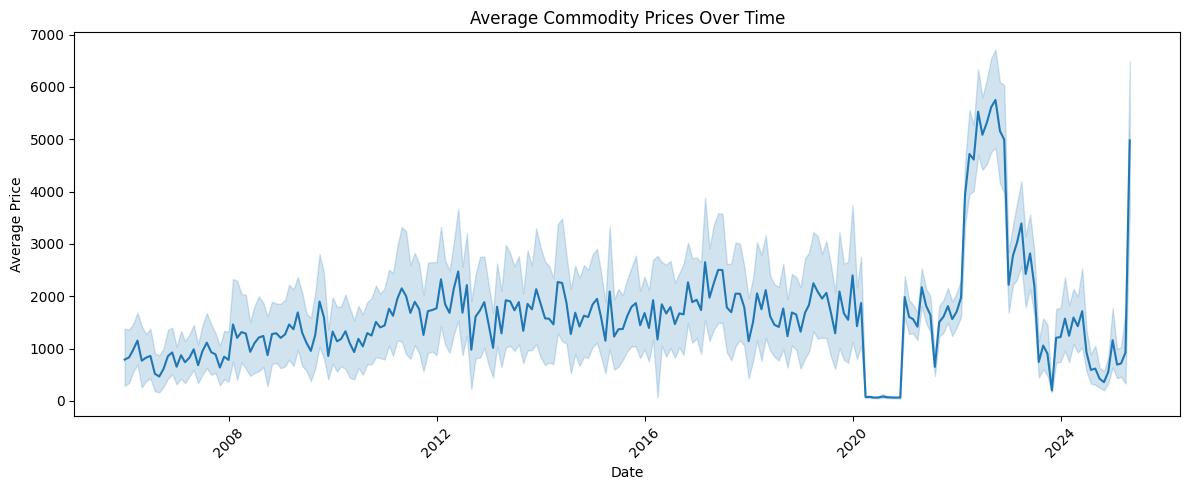

/var/folders/hk/9q5rgqm970gcnk6z0xvy1p7m0000gn/T/ipykernel_8200/3046244568.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_markets.values, y=top_markets.index, palette='viridis')


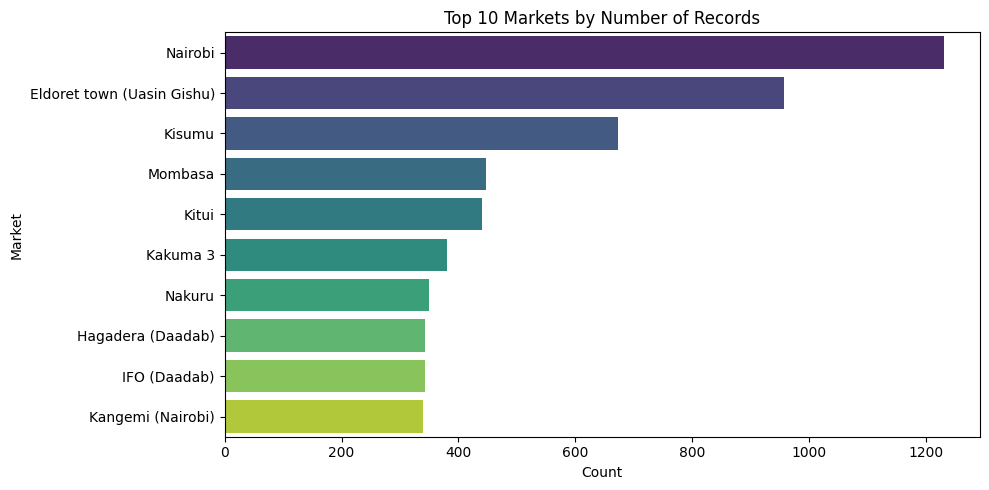

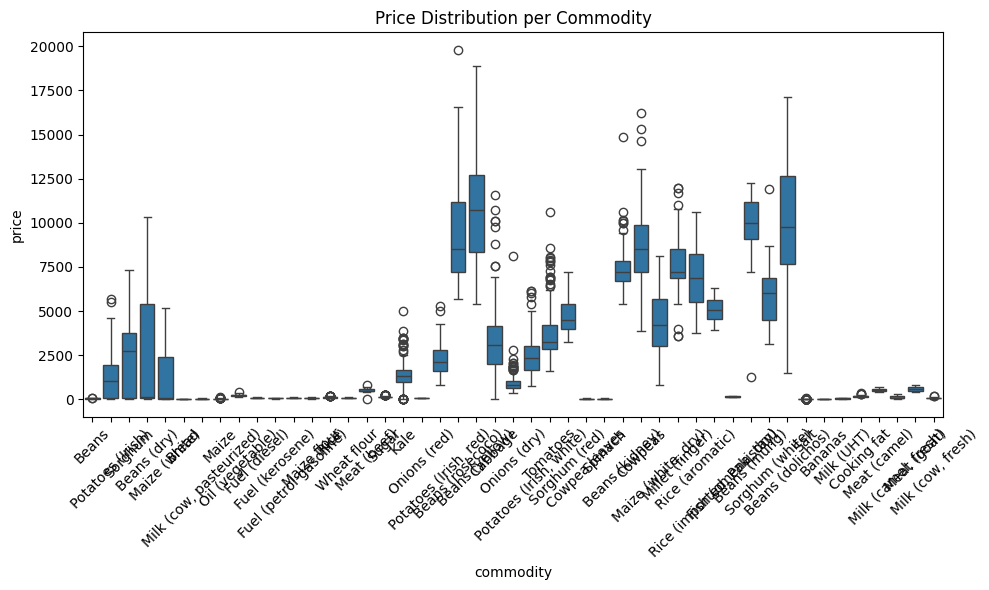

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
merged = pd.read_csv("merged_data.csv")

# Use 'date_x' for time-related EDA
if 'date_x' in merged.columns:
    merged['date_x'] = pd.to_datetime(merged['date_x'], errors='coerce')
    merged['year'] = merged['date_x'].dt.year
    merged['month'] = merged['date_x'].dt.month
    merged['date'] = pd.to_datetime(merged[['year', 'month']].assign(day=1))
else:
    raise KeyError("Column 'date_x' is missing. Please verify the dataset structure.")

#Summary
print(" Data Overview:")
print(merged.describe(include='all'))
print("\nMissing values:\n", merged.isnull().sum())

#Price Trends Over Time
plt.figure(figsize=(12, 5))
sns.lineplot(data=merged, x="date", y="price", estimator='mean')
plt.title("Average Commodity Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Average Price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Top 10 Markets by Records
top_markets = merged['market_x'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_markets.values, y=top_markets.index, palette='viridis')
plt.title("Top 10 Markets by Number of Records")
plt.xlabel("Count")
plt.ylabel("Market")
plt.tight_layout()
plt.show()

#Price Distribution by Commodity
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged, x='commodity', y='price')
plt.title("Price Distribution per Commodity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 1.3 Data Cleaning & Preparation

We clean the merged dataset by handling missing values, standardizing formats, and preparing it for modeling.


In [11]:
# 1.1 Remove duplicates & critical NaNs
df = merged.drop_duplicates()
df = df.dropna(subset=['price', 'rainfall_mm', 'commodity_id'])

# 1.2 Standardize date and numeric types
df['date'] = pd.to_datetime(df['date_x'])
df[['price', 'rainfall_mm']] = df[['price', 'rainfall_mm']].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=['price', 'rainfall_mm'])

# 1.4 Feature Engineering

We create new features from the cleaned data to improve model performance.  
This includes extracting date-based features, encoding categorical variables, and generating useful interaction terms.


In [12]:
# 2.1 Extract time features
df['month'] = df['date'].dt.month
df['year']  = df['date'].dt.year

# 2.2 Encode categorical variables
for col in ['commodity', 'market_x', 'admin1_x', 'admin2_x']:
    df[col] = df[col].astype('category').cat.codes

# 2.3 Scale numeric variables
from sklearn.preprocessing import StandardScaler
num_cols = ['rainfall_mm', 'month', 'year']
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# 2.4 Final feature matrix
features = ['rainfall_mm','month','year','commodity','market_x','admin1_x','admin2_x']
X = df[features]
y = df['price']


# 1.5 Train-Test Split & Data Structuring

We split the data into training and testing sets to evaluate model performance on unseen data.  
This ensures the model generalizes well and doesn't overfit the training data.


In [13]:
# 3.1 Split the dataset into training, validation, and test sets
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# 2.0 Model Configuration – Neural Network + 4 Baselines

We define a feedforward neural network using TensorFlow/Keras to model nonlinear relationships in the data.  
We also prepare baseline models (Ridge, Random Forest, Gradient Boosting) for comparison.


In [14]:
#importing necessary libraries
import numpy as np
from tensorflow import keras
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Build Neural Network
# -----------------------------
def build_nn_model(input_dim, config):
    inp = keras.Input(shape=(input_dim,))
    x = inp
    for h in config['hidden_units']:
        x = keras.layers.Dense(h, activation=config['activation'])(x)
        x = keras.layers.Dropout(config['dropout'])(x)
    out = keras.layers.Dense(1)(x)
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(config['lr']), loss='mse', metrics=['mae'])
    return model

## 2.1 Neural Network Configuration and Model Training

We configure the neural network with two hidden layers and ReLU activation.  
All models — including NeuralNet, Ridge, Random Forest, and Gradient Boosting — are trained and evaluated on the same dataset.

The best model is selected based on R² score and saved for deployment.


In [15]:
nn_config = {
    'hidden_units': [128, 64],
    'activation': 'relu',
    'dropout': 0.25,
    'lr': 1e-3,
    'batch_size': 64,
    'epochs': 50
}

# -----------------------------
#  Models
# -----------------------------
models = {
    'NeuralNet': build_nn_model(X_train.shape[1], nn_config),
    'RandomForest': RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=150, learning_rate=0.05, random_state=42),
    'Ridge': Ridge(alpha=0.5)
}

results = {}
metrics_summary = []
best_model_name = None
best_score = -np.inf

# Train, Predict, Evaluate
for name, model in models.items():
    print(f"\n Training {name}...")

    if name == 'NeuralNet':
        history = model.fit(X_train, y_train,
                            validation_data=(X_val, y_val),
                            batch_size=nn_config['batch_size'],
                            epochs=nn_config['epochs'],
                            verbose=0)
        preds = model.predict(X_test).flatten()
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

    # Metrics
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    metrics_summary.append({
        'Model': name,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'R2': round(r2, 3)
    })

    # Save model if best
    if r2 > best_score:
        best_model_name = name
        best_score = r2
        if name == 'NeuralNet':
            model.save('best_neural_net.h5')
        else:
            joblib.dump(model, f'best_model_{name}.pkl')

    results[name] = {
        'predictions': preds,
        'model_obj': model,
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    }


 Training NeuralNet...
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step



 Training RandomForest...

 Training GradientBoosting...

 Training Ridge...


## 2.2 Metrics Summary

We compare all models using standard regression metrics:  
- **MAE** (Mean Absolute Error)  
- **RMSE** (Root Mean Squared Error)  
- **R² Score** (Goodness of fit)

The model with the highest R² score is selected as the best-performing model for deployment.


In [16]:
print("\n Evaluation Summary:")
metrics_df = pd.DataFrame(metrics_summary)
print(metrics_df.sort_values(by='R2', ascending=False))


 Evaluation Summary:
              Model      MAE     RMSE     R2
1      RandomForest   385.97   801.86  0.921
2  GradientBoosting   957.77  1412.12  0.754
0         NeuralNet  1561.81  2232.69  0.384
3             Ridge  2048.13  2720.92  0.086


## 2.3 Visualize Performance

We use a horizontal bar plot to compare the **R² scores** of all models, highlighting overall model accuracy (higher is better).

The model with the highest R² score is selected as the best performer for deployment.


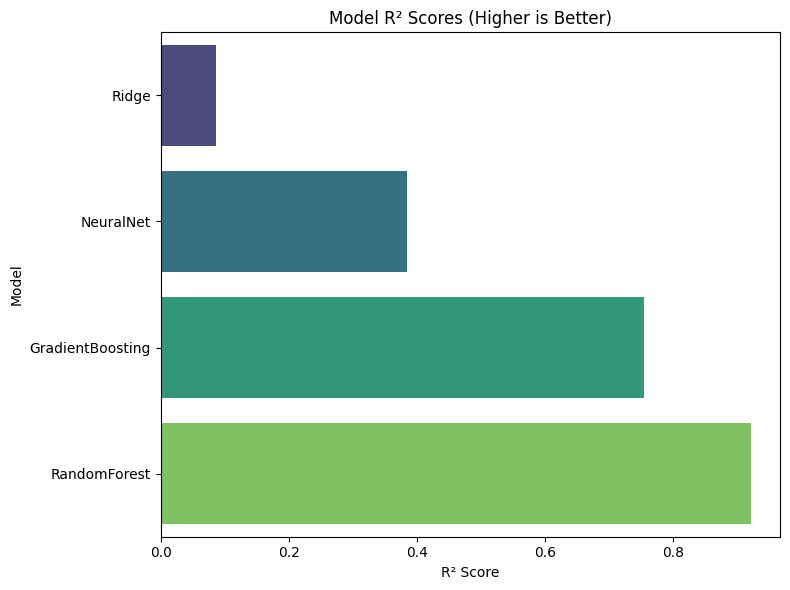


 Best Model: RandomForest with R² = 0.921


In [19]:
plt.figure(figsize=(8, 6))
sns.barplot(
    data=metrics_df.sort_values('R2'),
    x='R2',
    y='Model',
    hue='Model',           # Assign hue
    palette='viridis',
    dodge=False            # Optional: avoid multiple bars per model
)
plt.title("Model R² Scores (Higher is Better)")
plt.xlabel("R² Score")
plt.ylabel("Model")
plt.legend([], [], frameon=False)  # Remove the legend manually
plt.tight_layout()
plt.show()

# Print best model after visualization
print(f"\n Best Model: {best_model_name} with R² = {round(best_score, 3)}")


## 5.2 Comparison Table

This section will present a side-by-side summary of the performance metrics for all models evaluated:

- **MAE (Mean Absolute Error)**: Measures the average magnitude of errors in a set of predictions.
- **RMSE (Root Mean Squared Error)**: Similar to MAE but gives higher weight to large errors.
- **R² Score**: Indicates how well the model explains the variability of the target variable.

The table below (to be added) will help identify which model performed best across different metrics.


In [20]:
import pandas as pd

comparison_df = pd.DataFrame(metrics_summary)
print("\n Model Comparison:\n")
print(comparison_df.sort_values(by="RMSE"))


 Model Comparison:

              Model      MAE     RMSE     R2
1      RandomForest   385.97   801.86  0.921
2  GradientBoosting   957.77  1412.12  0.754
0         NeuralNet  1561.81  2232.69  0.384
3             Ridge  2048.13  2720.92  0.086


In [21]:
# Select best model based on lowest RMSE
best_model_name = comparison_df.sort_values(by="RMSE").iloc[0]['Model']
best_model = results[best_model_name]['model_obj']

print(f"\n Best model: {best_model_name}")

# Save model
if best_model_name == 'NeuralNet':
    best_model.save("best_model_nn.keras")
else:
    joblib.dump(best_model, "best_model.pkl")



 Best model: RandomForest


## 5.3 Recommend

This section provides a simple function to generate price predictions using the best-performing model.

It takes in rainfall, time, commodity, and location codes and returns the predicted price. The trained best model is used to provide estimates, which can support decision-making for farmers, traders, and policymakers.

In [23]:
def recommend_crop(rainfall_mm, month, year, commodity_code, market_code, admin1_code, admin2_code):
    import numpy as np
    # Load model
    model = joblib.load("best_model.pkl")

    # Input: must be 2D array with correct order
    X_new = np.array([[rainfall_mm, month, year, commodity_code, market_code, admin1_code, admin2_code]])

    # Predict price
    predicted_price = model.predict(X_new)[0]
    return predicted_price

In [24]:
# Example: rainfall=24mm, month=7, year=2025, commodity=67 (Maize), market_id=184, admin1=30, admin2=16
recommendation = recommend_crop(24.0, 7, 2025, 67, 184, 30, 16)
print(" Predicted Price:", round(recommendation, 2))

 Predicted Price: 2221.9


/Users/brianrono/anaconda3/envs/learn-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
